# Data Exploration

In [1]:
from DevelopedMethods.DF import *  # import np, pd, sklearn fn's --and df (https://www.kaggle.com/datasets/andrewmvd/heart-failure-clinical-data)

In [2]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


**notice <u>all numerical</u> features:**

**binary:** *smoking, sex, high_blood_pressure, diabetes, anaemia*

**non-binary:** *age, creatinine_phosphokinase, ejection_fraction, platelets, serum_creatinine, serum_sodium, time*

## Feature Matrix (X) & Target/label Vector (y)

In [4]:
df = df.drop(columns=['time']) # (future) event time (generated along w/ DEATH_EVENT) (or study length, study WILL end abrubtly from either LIVING & ending reporting, or DYING from 'Myocardial Infarction Event')
X = df.iloc[:, :-1]
y = df['DEATH_EVENT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

In [5]:
stages = dict(DF=X, y=y, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test) # make running code / plotting stages easier

## Check For Imbalance

In [6]:
tmp = pd.concat([y.value_counts(), y.value_counts(normalize=True) * 100, y_train.value_counts(), y_train.value_counts(normalize=True) * 100], axis=1)
tmp.columns = ['DEATH_EVENT value count: y', f'out of ({len(y)} samples)    %', 'DEATH_EVENT value count: y_train', f'out of ({len(y_train)} samples)   %']
tmp

,DEATH_EVENT value count: y,out of (299 samples) %,DEATH_EVENT value count: y_train,out of (239 samples) %
DEATH_EVENT,,,,
0,203,67.892977,160,66.945607
1,96,32.107023,79,33.054393


## Mild imbalance. Explore SMOTE, weighted loss functions, or threshold tuning.
1. **SMOTE (Synthetic Minority Over-sampling Technique):** This technique generates synthetic samples for the minority class (DEATH_EVENT) to balance the dataset. It's effective but can introduce noise.
1. **Weighted Loss Functions:** higher weights to minority class **during training**. This approach helps the model focus more on correctly predicting the minority class without altering the dataset.
1. **Threshold Tuning:** Adjust the decision threshold of your model's predictions to improve sensitivity for the minority class. This is useful **after model training**.

In [7]:
smote = SMOTE(random_state=55)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f"X_train ({len(X_train)}) => X_train_resampled ({len(X_train_resampled)})\n\n", y_train_resampled.value_counts())

X_train (239) => X_train_resampled (320)

 DEATH_EVENT
0    160
1    160
Name: count, dtype: int64


In [8]:
stages.update(dict(X_train_resampled=X_train_resampled, y_train_resampled=y_train_resampled))

**Detect SMOTE Noise:** PCA - SMOTE Original vs Synthetic Samples

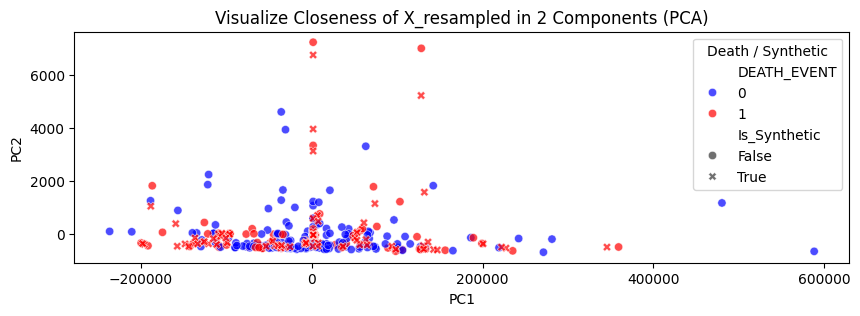

In [9]:
pca = PCA(n_components=2, random_state=55) # apply PCA to reduce 2D (2 features) —for visualization
X_resampled_pca = pca.fit_transform(X_train_resampled)

plot_df = pd.DataFrame(X_resampled_pca, columns=["PC1", "PC2"])
plot_df["DEATH_EVENT"] = y_train_resampled
plot_df["Is_Synthetic"] = np.array([False]*len(X_train) + [True]*(len(X_train_resampled) - len(X_train))) # [...original, ...synthetic] (SMOTE adds synthetic samples @ end)

plt.figure(figsize=(10, 3))
sns.scatterplot(
    data=plot_df,
    x="PC1", y="PC2",
    hue="DEATH_EVENT",
    style="Is_Synthetic",
    palette={0: "blue", 1: "red"},
    markers={False: "o", True: "X"},
    alpha=0.7
)
plt.title("Visualize Closeness of X_resampled in 2 Components (PCA)")
plt.legend(title="Death / Synthetic")
plt.show()


Blue circles = majority class original

Red circles = minority class original

Red X’s = synthetic samples added by SMOTE

... No outliers => no noise found. &nbsp; ie: &nbsp; X's (synthetic) are all near red circles (original's from minority class)

**Detect SMOTE Noise (2):**

**<u>t-SNE</u>** (t-Distributed Stochastic Neighbor Embedding) ...to inspect tighter clusters ——better than PCA at preserving local structure

**more info:** converts the distances between points into probabilities -> 2d. then reduces the "crowding problem" with "Student's t-Distribution". iteratively minimizes divergence between 2d and n-dimension probability distributions.

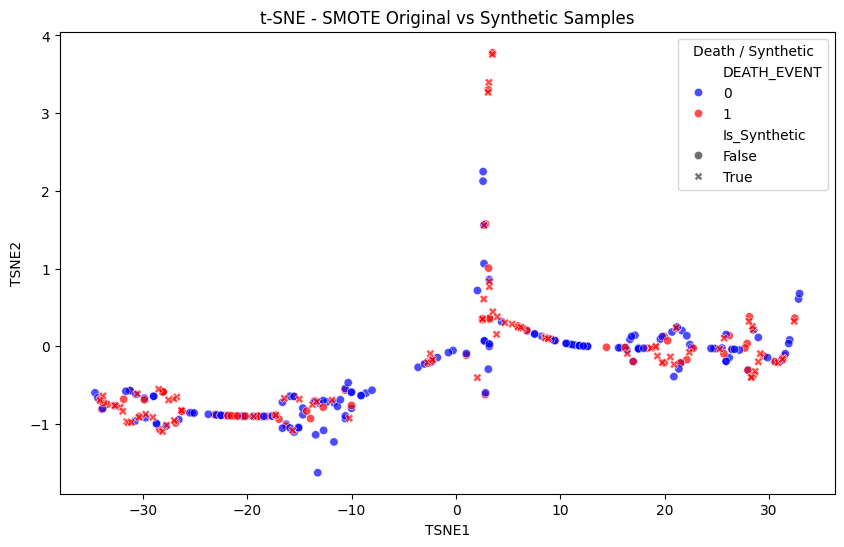

In [10]:
tsne = TSNE(n_components=2, random_state=55, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_train_resampled)

tsne_df = pd.DataFrame(X_tsne, columns=["TSNE1", "TSNE2"])
tsne_df["DEATH_EVENT"] = y_train_resampled
tsne_df["Is_Synthetic"] = plot_df["Is_Synthetic"] # [...original, ...synthetic]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=tsne_df,
    x="TSNE1", y="TSNE2",
    hue="DEATH_EVENT",
    style="Is_Synthetic",
    palette={0: "blue", 1: "red"},
    markers={False: "o", True: "X"},
    alpha=0.7
)
plt.title("t-SNE - SMOTE Original vs Synthetic Samples")
plt.legend(title="Death / Synthetic")
plt.show()


we see the same (but with a better view) &nbsp; ——synthetic samples all very close to original samples

# ModelMetrics(): Fit (on _train) + Predict (on _test) + Score (<u>types:</u> accuracy_score, Cross Validation (CV), F1 CV, ROC CV)

In [11]:
f1_scorer = metrics.make_scorer(metrics.f1_score)

class ModelMetrics(): # notice: we are doing CV w/ train_test_split... only AUC seems to fluctuate w/o
    def __init__(self, algo, X_train, X_test, y_train, y_test):
        self.model = algo
        # accuracy_score
        algo.fit(X_train, y_train)
        self.predictions = algo.predict(X_test)
        self.acc = metrics.accuracy_score(y_test, self.predictions)
        # cross validation
        self.cv = cross_val_score(algo, X_train, y_train, cv=10)
        self.cv_mean = self.cv.mean()
        # F1 (w/ cross validation)
        self.f1_cv = cross_val_score(algo, X_train, y_train, cv=10, scoring=f1_scorer)
        self.f1 = self.f1_cv.mean()
        if algo.__class__.__name__ in ["KMeans"]: # unsupervised algos w/o predict_proba (eg: kmeans)
            self.roc_AUC = None
            return
        # roc_curve AUC (w/ cross validation)
        y_scores = cross_val_predict(algo, X_train, y_train, cv=10, method='predict_proba')[:, 1]
        roc_fpr, roc_tpr, roc_thresholds = metrics.roc_curve(y_train, y_scores)
        self.roc_fpr = roc_fpr
        self.roc_tpr = roc_tpr
        self.roc_thresholds = roc_thresholds
        self.roc_AUC = metrics.roc_auc_score(y_test, algo.predict_proba(X_test)[:,1])

    def __repr__(self):
        return f"""\n        acc: {self.acc}
        cv_mean: {self.cv_mean}
        f1: {self.f1}
        roc_AUC: {self.roc_AUC}"""

# Feature Importance Analysis

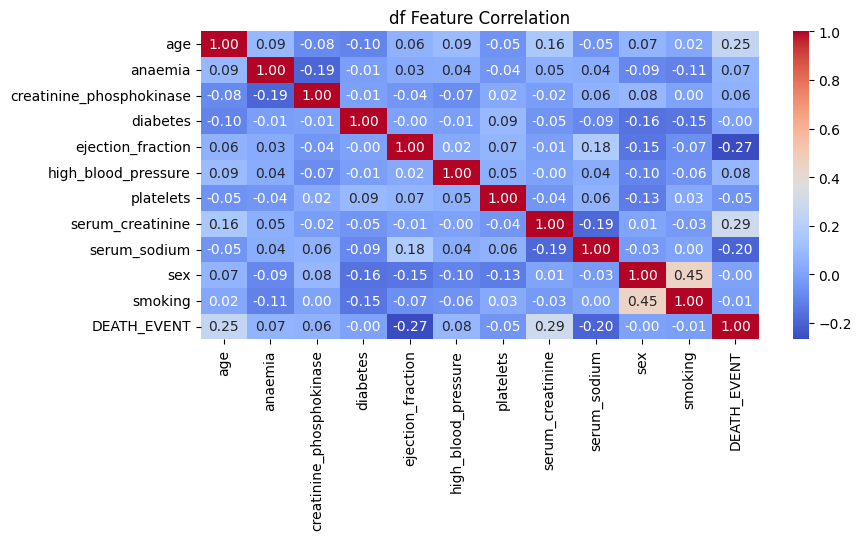

In [12]:
plt.figure(figsize=(9, 4))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('df Feature Correlation')
plt.show()

### Decision Tree

In [13]:
decisiontree = DecisionTreeClassifier(random_state=55) # invariant to feature scaling
decisiontree_resampled = DecisionTreeClassifier(random_state=55)
models = dict(decisiontree=ModelMetrics(decisiontree, X_train, X_test, y_train, y_test),
     decisiontree_resampled=ModelMetrics(decisiontree_resampled, X_train_resampled, X_test, y_train_resampled, y_test))
models

{'decisiontree': 
         acc: 0.6833333333333333
         cv_mean: 0.6655797101449274
         f1: 0.46938034188034183
         roc_AUC: 0.6012311901504787,
 'decisiontree_resampled': 
         acc: 0.6666666666666666
         cv_mean: 0.7125
         f1: 0.7072444531120838
         roc_AUC: 0.5896032831737346}

#### Decision Tree — Feature Importance Analysis

In [14]:
tmp1 = pd.DataFrame({'feature': X.columns, 'importance': decisiontree.feature_importances_ * 100})
tmp1 = tmp1.sort_values(by='importance', ascending=False).reset_index(drop=True)
tmp2 = pd.DataFrame({'feature': X.columns, 'importance': decisiontree_resampled.feature_importances_ * 100})
tmp2 = tmp2.sort_values(by='importance', ascending=False).reset_index(drop=True)
tmp = pd.DataFrame({
    'best_ft': tmp1['feature'],
    'importance %': tmp1['importance'],
    '': pd.Series([""] * len(X.columns)), '&nbsp;': pd.Series([""] * len(X.columns)), # separator/padding cols
    'best_ft_resampled': tmp2['feature'],
    'importance % resampled': tmp2['importance'],
})
tmp.index += 1 # indexing starts @ 1
tmp

,best_ft,importance %,,&nbsp;,best_ft_resampled,importance % resampled
1,serum_creatinine,27.976344,,,serum_creatinine,27.158690
2,platelets,20.023063,,,ejection_fraction,17.391362
3,ejection_fraction,17.051321,,,serum_sodium,15.552510
4,age,11.752735,,,creatinine_phosphokinase,14.456821
5,creatinine_phosphokinase,10.709853,,,platelets,11.167325
6,serum_sodium,8.705038,,,age,7.375782
7,sex,2.363528,,,sex,2.306164
8,smoking,1.418117,,,smoking,1.778846
9,anaemia,0.000000,,,anaemia,1.770833
10,diabetes,0.000000,,,high_blood_pressure,1.041667


most notable importance fluctuations: &nbsp; ejection_fraction ± 4.5%, &nbsp; age ± 3%

### Random Forest

In [15]:
randomforest = RandomForestClassifier(random_state=55, bootstrap=True, n_estimators=25) # invariant to feature scaling
randomforest_resampled = RandomForestClassifier(random_state=55, bootstrap=True, n_estimators=69)

# """Grid Search (Best n_estimators  between: [1-100, 101-500 (step 5))]"""
# rf = RandomForestClassifier(random_state=55) # grid search for best F1 n_estimators (X_train & X_train_resampled)
# grid = GridSearchCV(estimator=rf, param_grid={'n_estimators': list(range(1, 100)) + list(range(101, 500, 5))}, cv=5, scoring='f1', n_jobs=-1)
# grid.fit(X_train, y_train)
# print(f"Best n_estimators for X_train: {grid.best_params_['n_estimators']}")
# grid.fit(X_train_resampled, y_train_resampled)
# print(f"Best n_estimators for X_train_resampled: {grid.best_params_['n_estimators']}")

new_models = dict(randomforest=ModelMetrics(randomforest, X_train, X_test, y_train, y_test),
        randomforest_resampled=ModelMetrics(randomforest_resampled, X_train_resampled, X_test, y_train_resampled, y_test))
models.update(new_models)
new_models

{'randomforest': 
         acc: 0.7166666666666667
         cv_mean: 0.7536231884057971
         f1: 0.578076923076923
         roc_AUC: 0.7400820793433652,
 'randomforest_resampled': 
         acc: 0.7166666666666667
         cv_mean: 0.815625
         f1: 0.8169773531422138
         roc_AUC: 0.7585499316005472}

#### Random Forest — Feature Importance Analysis

In [16]:
tmp1 = pd.DataFrame({'feature': X.columns, 'importance': randomforest.feature_importances_ * 100})
tmp1 = tmp1.sort_values(by='importance', ascending=False).reset_index(drop=True)
tmp2 = pd.DataFrame({'feature': X.columns, 'importance': randomforest_resampled.feature_importances_ * 100})
tmp2 = tmp2.sort_values(by='importance', ascending=False).reset_index(drop=True)
tmp = pd.DataFrame({
    'best_ft': tmp1['feature'],
    'importance %': tmp1['importance'],
    '': pd.Series([""] * len(X.columns)), '&nbsp;': pd.Series([""] * len(X.columns)), # separator/padding cols
    'best_ft_resampled': tmp2['feature'],
    'importance % resampled': tmp2['importance'],
})
tmp.index += 1 # indexing starts @ 1
tmp

,best_ft,importance %,,&nbsp;,best_ft_resampled,importance % resampled
1,serum_creatinine,21.863303,,,serum_creatinine,24.140932
2,ejection_fraction,16.279217,,,ejection_fraction,17.680620
3,age,15.091571,,,age,13.139497
4,serum_sodium,12.298981,,,creatinine_phosphokinase,12.507009
5,platelets,11.894348,,,platelets,11.102209
6,creatinine_phosphokinase,11.278206,,,serum_sodium,10.854332
7,smoking,2.775716,,,sex,3.317297
8,diabetes,2.574449,,,smoking,2.110542
9,sex,2.194040,,,diabetes,1.846204
10,anaemia,2.052310,,,high_blood_pressure,1.680442


no huge fluctuations (little noise), but confirms most of decision tree: (ie: 1: time, 2: serum_creatinine, 3: ¿ejection_fraction?/creatinine_phosphokinase, platelets/age, serum_sodium, ...)

# Choosing a Scaler Function:

Inspect Gaussian Distribution (of values) across stages: (ie: X, X_train, X_train_resampled)

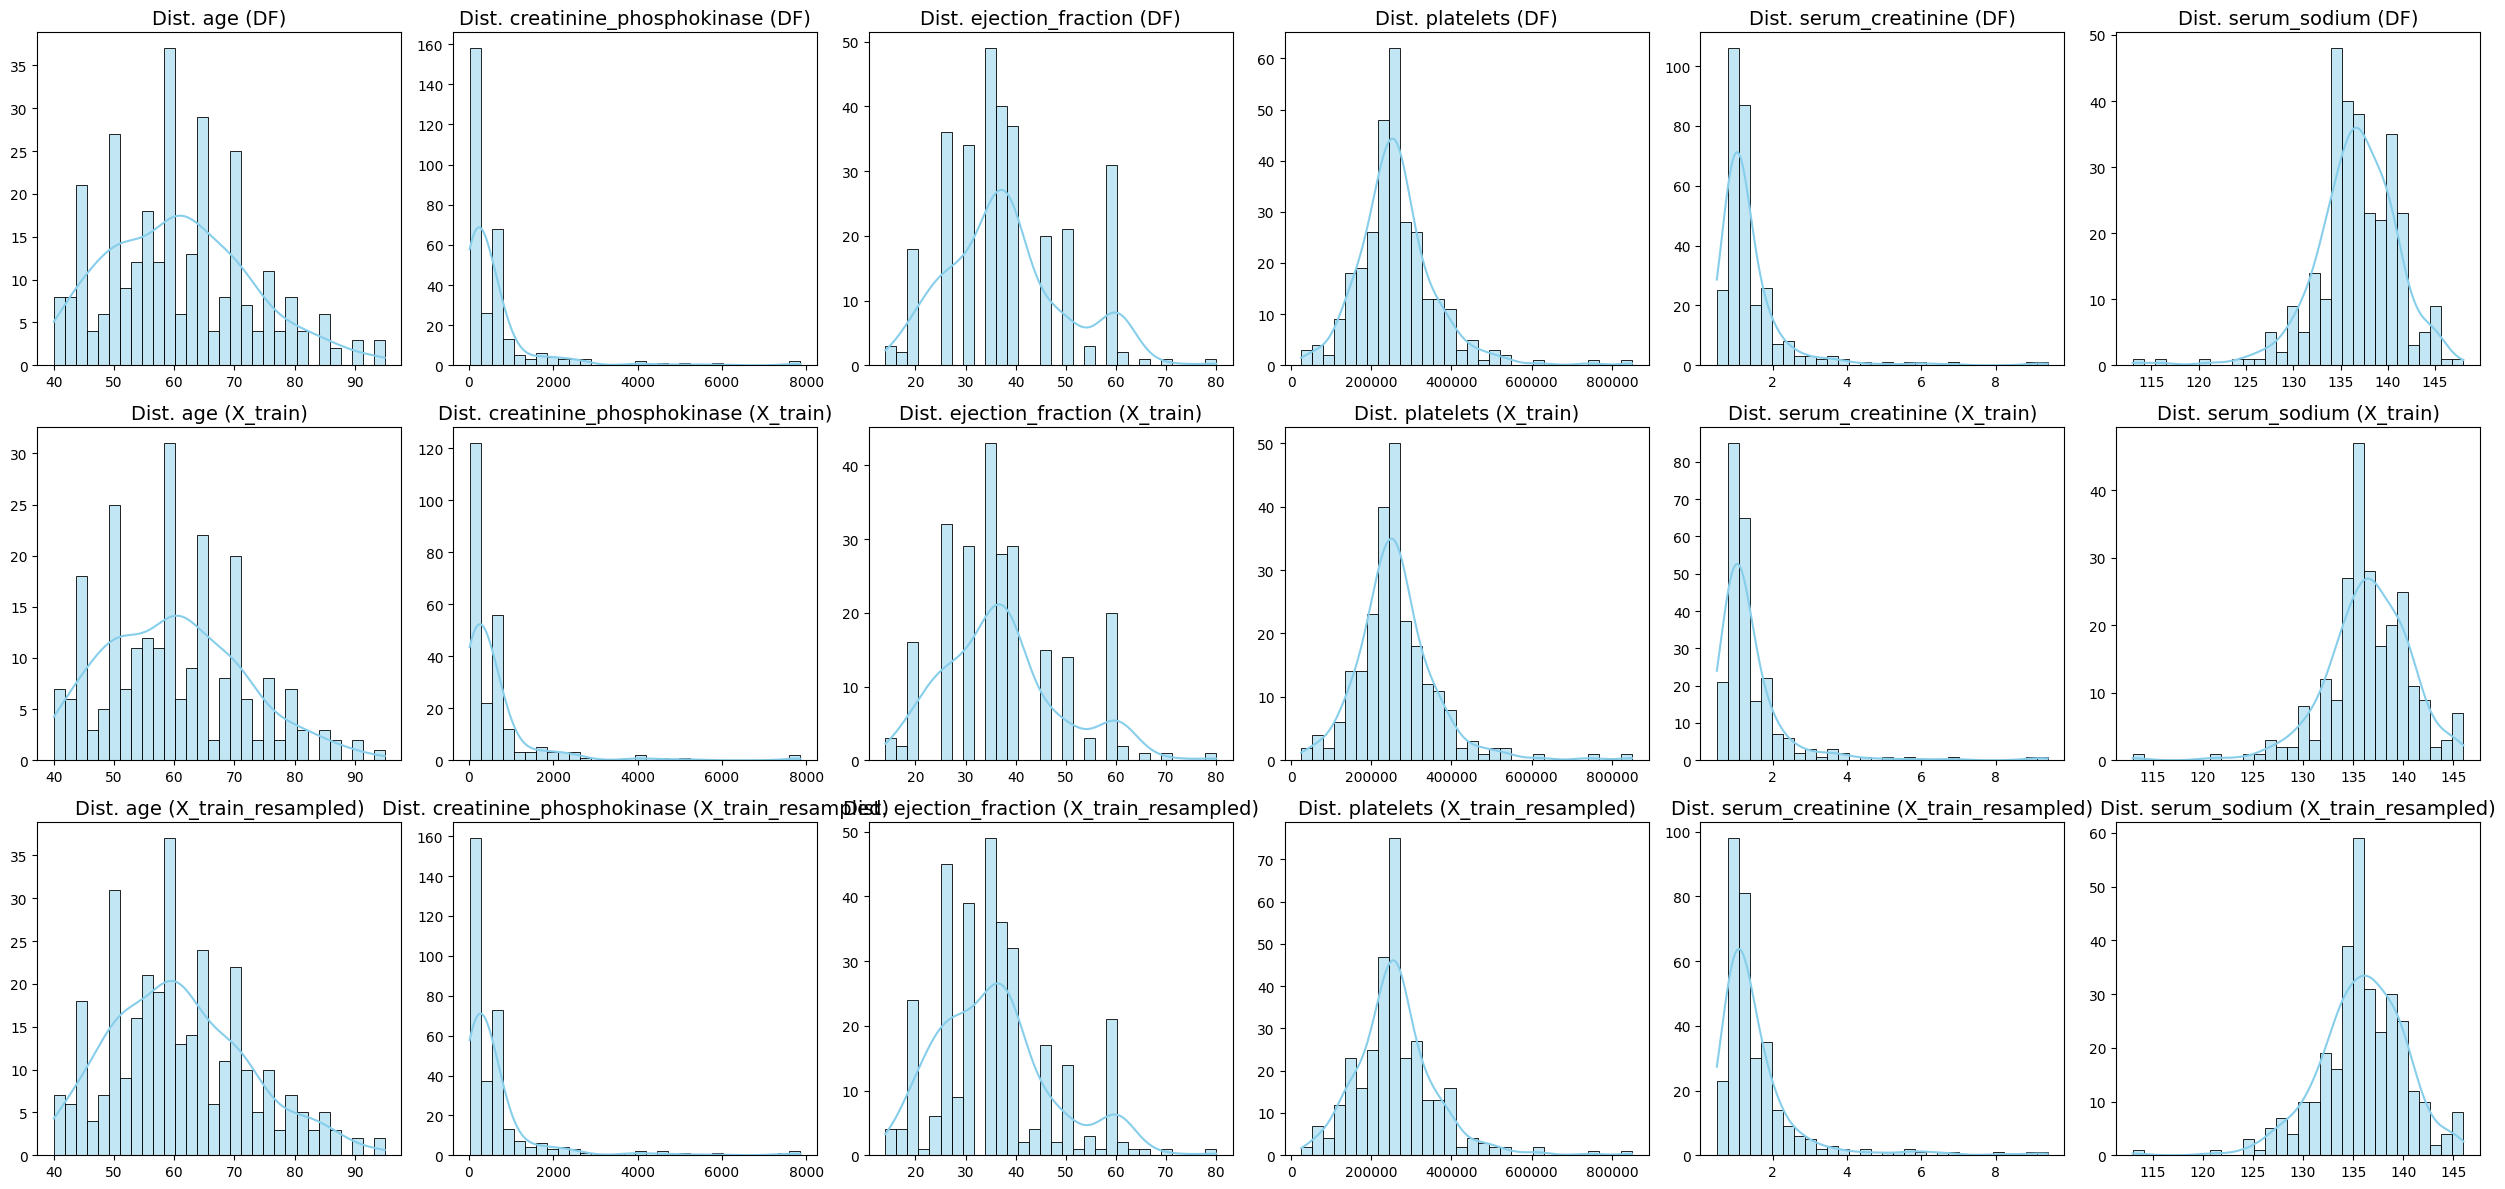

In [17]:
non_binary_features = ["age", "creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium"]
_stages = dict()
for i in stages:
    if i.startswith("y") or i.find("_test") != -1: continue
    _stages[i] = stages[i]
rows = len(_stages) # 3
cols = len(non_binary_features)
plt.figure(figsize=(25, 12))
for i, df_key in enumerate(_stages.keys()):
    for j, feature in enumerate(non_binary_features):
        plot_no = i * cols + j + 1
        plt.subplot(rows, cols, plot_no) # focus plot_no in rowsXcols super-plot
        sns.histplot(_stages[df_key][feature], kde=True, bins=30, color='skyblue') # draw plot histogram w/ KDE "Kernel Density Estimate" (curve)
        plt.title(f"Dist. {feature} ({df_key})", fontsize=14)
        plt.xlabel(None)
        plt.ylabel(None)
plt.tight_layout()
plt.show()

These are the counts of the popularity of each non-binary feature-values in the datset. (ie: age: 60 is the most common in the dataset (see: the tallest bar/pile))

If Gaussian, KDE curve resembles a bell shape centered around the mean... Kernel Density Estimate/KDE curve is a smoothed approximation of feature-value distribution –like a continuous version of histogram)

**Observations**: &nbsp; Gaussian w/ few peaks; &nbsp; using SMOTE/resampled leads to following Gaussian curve more closely

=> use StandardScaler (Z-score normalization)


## Normalize/Scale

In [18]:
scaler = StandardScaler() # mean=0, standard deviation=1
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns, index=X_test.index)
X_train_resampled_scaled = pd.DataFrame(scaler.fit_transform(X_train_resampled), columns=X.columns, index=X_train_resampled.index)

minmax_scaler = MinMaxScaler() # values range [0,...,1]      **——note:** ANN often benefits from MinMaxScaler &nbsp; &nbsp;(likewise for SVM w/ StandardScaler)
X_train_minmax = pd.DataFrame(minmax_scaler.fit_transform(X_train), columns=X.columns, index=X_train.index)
X_test_minmax = pd.DataFrame(minmax_scaler.transform(X_test), columns=X.columns, index=X_test.index)
X_train_resampled_minmax = pd.DataFrame(minmax_scaler.fit_transform(X_train_resampled), columns=X.columns, index=X_train_resampled.index)

In [19]:
stages.update(dict(X_train_scaled=X_train_scaled, X_test_scaled=X_test_scaled, X_train_resampled_scaled=X_train_resampled_scaled, X_train_minmax=X_train_minmax, X_test_minmax=X_test_minmax, X_train_resampled_minmax=X_train_resampled_minmax))

# Begin Classification Problem [0, 1] — Heart Failure Detection
Try traditional algorithms on: X_train, X_train_scaled, X_train_resampled, X_train_resampled_scaled

Logistic Regression

In [20]:
# scaling improves gradient descent/convergence speed (and won't need 'max_iter' increase)
logisticregression = linear_model.LogisticRegression(random_state=55, max_iter=2000)
logisticregression_scaled = linear_model.LogisticRegression(random_state=55)
logisticregression_resampled = linear_model.LogisticRegression(random_state=55, max_iter=4000)
logisticregression_resampled_scaled = linear_model.LogisticRegression(random_state=55)
new_models = dict(logisticregression=ModelMetrics(logisticregression, X_train, X_test, y_train, y_test),
        logisticregression_scaled=ModelMetrics(logisticregression_scaled, X_train_scaled, X_test_scaled, y_train, y_test),
     logisticregression_resampled=ModelMetrics(logisticregression_resampled, X_train_resampled, X_test, y_train_resampled, y_test),
logisticregression_resampled_scaled=ModelMetrics(logisticregression_resampled_scaled, X_train_resampled_scaled, X_test_scaled, y_train_resampled, y_test))
models.update(new_models)
new_models

{'logisticregression': 
         acc: 0.7166666666666667
         cv_mean: 0.7534420289855073
         f1: 0.5463318544200898
         roc_AUC: 0.7578659370725035,
 'logisticregression_scaled': 
         acc: 0.75
         cv_mean: 0.7326086956521739
         f1: 0.5062803209862033
         roc_AUC: 0.7633378932968536,
 'logisticregression_resampled': 
         acc: 0.7333333333333333
         cv_mean: 0.7625
         f1: 0.7609816018497233
         roc_AUC: 0.7113543091655267,
 'logisticregression_resampled_scaled': 
         acc: 0.6833333333333333
         cv_mean: 0.74375
         f1: 0.7387333301156668
         roc_AUC: 0.7099863201094391}

K-Nearest-Neighbors (KNN)

In [21]:
k = 3 # best results w/ 3 then 18
knn = KNeighborsClassifier(n_neighbors=k, weights='uniform') # scaling is essential.
knn_scaled = KNeighborsClassifier(n_neighbors=k, weights='uniform')
knn_resampled = KNeighborsClassifier(n_neighbors=k, weights='uniform')
knn_resampled_scaled = KNeighborsClassifier(n_neighbors=k, weights='uniform')
new_models = dict(knn=ModelMetrics(knn, X_train, X_test, y_train, y_test),
        knn_scaled=ModelMetrics(knn_scaled, X_train_scaled, X_test_scaled, y_train, y_test),
     knn_resampled=ModelMetrics(knn_resampled, X_train_resampled, X_test, y_train_resampled, y_test),
knn_resampled_scaled=ModelMetrics(knn_resampled_scaled, X_train_resampled_scaled, X_test_scaled, y_train_resampled, y_test))
models.update(new_models)
new_models

{'knn': 
         acc: 0.6166666666666667
         cv_mean: 0.5817028985507247
         f1: 0.294008148714031
         roc_AUC: 0.38372093023255816,
 'knn_scaled': 
         acc: 0.6666666666666666
         cv_mean: 0.6693840579710145
         f1: 0.36129424497071555
         roc_AUC: 0.5759233926128591,
 'knn_resampled': 
         acc: 0.5
         cv_mean: 0.6
         f1: 0.6143248470226503
         roc_AUC: 0.4083447332421341,
 'knn_resampled_scaled': 
         acc: 0.6166666666666667
         cv_mean: 0.70625
         f1: 0.69750825262783
         roc_AUC: 0.6046511627906976}

synthetic samples may have helped (extra neighbors)

K-Means Clustering

In [45]:
kmeans = KMeans(random_state=55, n_clusters=2) # scaling is essential.
kmeans_scaled = KMeans(random_state=55, n_clusters=2)
kmeans_resampled = KMeans(random_state=55, n_clusters=2)
kmeans_resampled_scaled = KMeans(random_state=55, n_clusters=2)
new_models = dict(kmeans=ModelMetrics(kmeans, X_train, X_test, y_train, y_test),
        kmeans_scaled=ModelMetrics(kmeans_scaled, X_train_scaled, X_test_scaled, y_train, y_test),
     kmeans_resampled=ModelMetrics(kmeans_resampled, X_train_resampled, X_test, y_train_resampled, y_test),
kmeans_resampled_scaled=ModelMetrics(kmeans_resampled_scaled, X_train_resampled_scaled, X_test_scaled, y_train_resampled, y_test))
models.update(new_models)
new_models

{'kmeans': 
         acc: 0.65
         cv_mean: -132186603818.57547
         f1: 0.4476967010999995
         roc_AUC: None,
 'kmeans_scaled': 
         acc: 0.5
         cv_mean: -242.77855220486413
         f1: 0.34876611686858366
         roc_AUC: None,
 'kmeans_resampled': 
         acc: 0.5166666666666667
         cv_mean: -172997795126.6251
         f1: 0.4110855773814617
         roc_AUC: None,
 'kmeans_resampled_scaled': 
         acc: 0.5666666666666667
         cv_mean: -323.4060000531022
         f1: 0.4760673164917553
         roc_AUC: None}

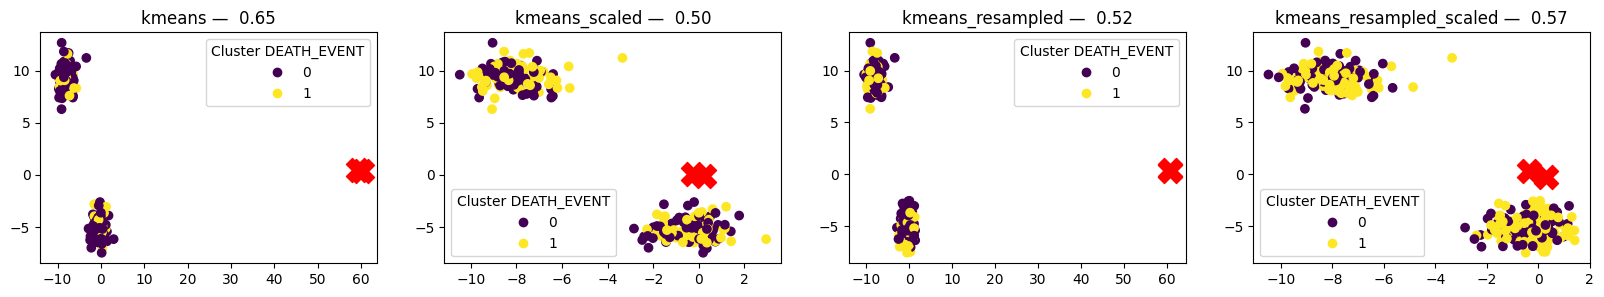

In [47]:
fig, axes = plt.subplots(1, 4, figsize=(20, 3))  # 1 row, 2 columns
for i, model_name in enumerate(new_models):
    model = new_models[model_name].model
    X_blobs, y_blobs = make_blobs(n_samples=len(X_train if model_name.find('resampled') == -1 else X_train_resampled), centers=2, random_state=55) # sklearn.datasets
    scatter = axes[i].scatter(X_blobs[:, 0], X_blobs[:, 1], c=model.labels_, cmap='viridis', marker='o')
    axes[i].scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], s=300, c='red', marker='X')
    axes[i].set_title(f"{model_name} —  {new_models[model_name].acc:.2f}")
    axes[i].legend(*scatter.legend_elements(), title="Cluster DEATH_EVENT")  # Cluster color legend
plt.show()

Naive-Bayes

In [24]:
naivebayes = GaussianNB()
naivebayes_scaled = GaussianNB()
naivebayes_resampled = GaussianNB()
naivebayes_resampled_scaled = GaussianNB()
new_models = dict(naivebayes=ModelMetrics(naivebayes, X_train, X_test, y_train, y_test),
        naivebayes_scaled=ModelMetrics(naivebayes_scaled, X_train_scaled, X_test_scaled, y_train, y_test),
     naivebayes_resampled=ModelMetrics(naivebayes_resampled, X_train_resampled, X_test, y_train_resampled, y_test),
naivebayes_resampled_scaled=ModelMetrics(naivebayes_resampled_scaled, X_train_resampled_scaled, X_test_scaled, y_train_resampled, y_test))
models.update(new_models)
new_models

{'naivebayes': 
         acc: 0.7333333333333333
         cv_mean: 0.6903985507246377
         f1: 0.2898989898989899
         roc_AUC: 0.8002735978112174,
 'naivebayes_scaled': 
         acc: 0.7333333333333333
         cv_mean: 0.7072463768115942
         f1: 0.3788644688644689
         roc_AUC: 0.7838577291381669,
 'naivebayes_resampled': 
         acc: 0.8
         cv_mean: 0.665625
         f1: 0.6225056420940737
         roc_AUC: 0.7961696306429549,
 'naivebayes_resampled_scaled': 
         acc: 0.7166666666666667
         cv_mean: 0.6875
         f1: 0.613926863796429
         roc_AUC: 0.7072503419972639}

# Sort models by metrics (with weights)

In [25]:
weights = {'f1': 0.5, 'roc_AUC': 0.3, 'cv_mean': 0.2} # medical application like: f1 > roc/auc > cv_mean # todo: add thresholds (ie: minimum f1 score)
for model_name, model in models.items():
    w_f1 = weights['f1'] if model.roc_AUC is not None else weights['f1'] + weights['roc_AUC']/2
    w_cv = weights['cv_mean'] if model.roc_AUC is not None else weights['cv_mean'] + weights['roc_AUC']/2
    model.composite_score = (w_f1 * model.f1 + weights['roc_AUC'] * (model.roc_AUC or 0) + w_cv * model.cv_mean)
pd.DataFrame({"sorted models": sorted(models.items(), key=lambda item: item[1].composite_score, reverse=True)})

,sorted models
0,"(randomforest_resampled, \n acc: 0.7166..."
1,"(logisticregression_resampled, \n acc: ..."
2,"(logisticregression_resampled_scaled, \n ..."
3,"(naivebayes_resampled, \n acc: 0.8\n ..."
4,"(decisiontree_resampled, \n acc: 0.6666..."
5,"(knn_resampled_scaled, \n acc: 0.616666..."
6,"(randomforest, \n acc: 0.71666666666666..."
7,"(naivebayes_resampled_scaled, \n acc: 0..."
8,"(logisticregression, \n acc: 0.71666666..."
9,"(logisticregression_scaled, \n acc: 0.7..."


**Best F1:** &nbsp; randomforest_resampled

**Best roc_AUC:** &nbsp; naivebayes_resampled

**Best cv_mean:** &nbsp; randomforest_resampled

## Try PCA for 1 to n-1 components on: X_train, X_train_scaled X_train_resampled_scaled

In [26]:
# stages.keys() # ['DF', 'X_train', 'X_train_resampled', 'X_train_scaled', 'X_test_scaled', 'X_train_resampled_scaled', 'X_train_minmax', 'X_test_minmax', 'X_train_resampled_minmax']
algos = dict( # (algo, args/params) tuples
    decisiontree=(DecisionTreeClassifier, dict(random_state=55)),
    randomforest=(RandomForestClassifier, dict(random_state=55, n_estimators=25, bootstrap=True)), # todo: try different n w/ pca's
    logisticregression=(linear_model.LogisticRegression, dict(random_state=55, max_iter=10000)),
    knn=(KNeighborsClassifier, dict(n_neighbors=3, weights='uniform')), # todo: try different n w/ pca's
    kmeans=(KMeans, dict(random_state=55, n_clusters=2)),
    naivebayes=(GaussianNB, dict())
)
pcas = dict()

def get_stage(stage_key): # DF|X|Y => '',  X_train => '_train',  X_train_resampled => '_train_resampled',  etc.
    if stage_key == 'DF' or stage_key == 'X' or stage_key == 'y': return ''
    return stage_key[1:]

def get_y_stage(stage_key): # same as above
    stage_key = stage_key.replace('_scaled', '').replace('_minmax', '') # but: you don't scale y's
    if stage_key == 'DF' or stage_key == 'X' or stage_key == 'y': return ''
    return stage_key[1:]

for algo_key, algo in algos.items():
    for num_fts in range(1, len(X.columns)):
        for stage_key, stage in stages.items():
            if stage_key.startswith('y') or stage_key.find("_test") != -1 or get_stage(stage_key) == '': continue # don't train on _test's, y's, or stageless (overfit from training & testing on same)
            pca_key = f"{algo_key}{get_stage(stage_key)}_{num_fts}"
            pcas[pca_key] = dict(pca=PCA(n_components=num_fts),)
            pcas[pca_key]["stage"] = pcas[pca_key]["pca"].fit_transform(stage) # PCA sub-stage/dataframe
            test_stage_key = f"{stage_key.replace('_train', '_test').replace('_resampled', '')}"
            pcas[pca_key]["test_stage"] = pcas[pca_key]["pca"].transform(stages[test_stage_key]) # PCA sub-stage/dataframe   ——you don't resample testing (don't test synthetic)
            pcas[pca_key]["model"] = ModelMetrics(algo[0](**algo[1]), pcas[pca_key]["stage"], pcas[pca_key]["test_stage"], stages[f"y{get_y_stage(stage_key)}"], stages[f"y{test_stage_key.replace('DF', 'x').replace('_scaled', '').replace('_minmax', '')[1:]}"])

generates
```
pcas["kmeans_train_resampled_scaled_9"]["model"].predictions
pcas["decisiontree_8"]["pca"].components_
pcas["decisiontree_train_11"]["pca"].explained_variance_
```
etc.

# Sort pca-models by metrics (with weights)

In [27]:
tmp = {}
for model_name in pcas:
    model = pcas[model_name]["model"]
    w_f1 = weights['f1'] if model.roc_AUC is not None else weights['f1'] + weights['roc_AUC']/2
    w_cv = weights['cv_mean'] if model.roc_AUC is not None else weights['cv_mean'] + weights['roc_AUC']/2
    model.composite_score = (w_f1 * model.f1 + weights['roc_AUC'] * (model.roc_AUC or 0) + w_cv * model.cv_mean)
    tmp[model_name] = model
pd.DataFrame({"sorted pca models": sorted(tmp.items(), key=lambda item: item[1].composite_score, reverse=True)})

,sorted pca models
0,"(randomforest_train_resampled_10, \n ac..."
1,"(randomforest_train_resampled_7, \n acc..."
2,"(randomforest_train_resampled_9, \n acc..."
3,"(randomforest_train_resampled_scaled_9, \n ..."
4,"(randomforest_train_resampled_6, \n acc..."
...,...
355,"(kmeans_train_resampled_6, \n acc: 0.51..."
356,"(kmeans_train_resampled_7, \n acc: 0.51..."
357,"(kmeans_train_resampled_8, \n acc: 0.51..."
358,"(kmeans_train_resampled_9, \n acc: 0.51..."


As expected, the PCA models are all less accurate for our application (medical datasets are known for low volume, highly related / low redundancy features).

# Traditional Method Results

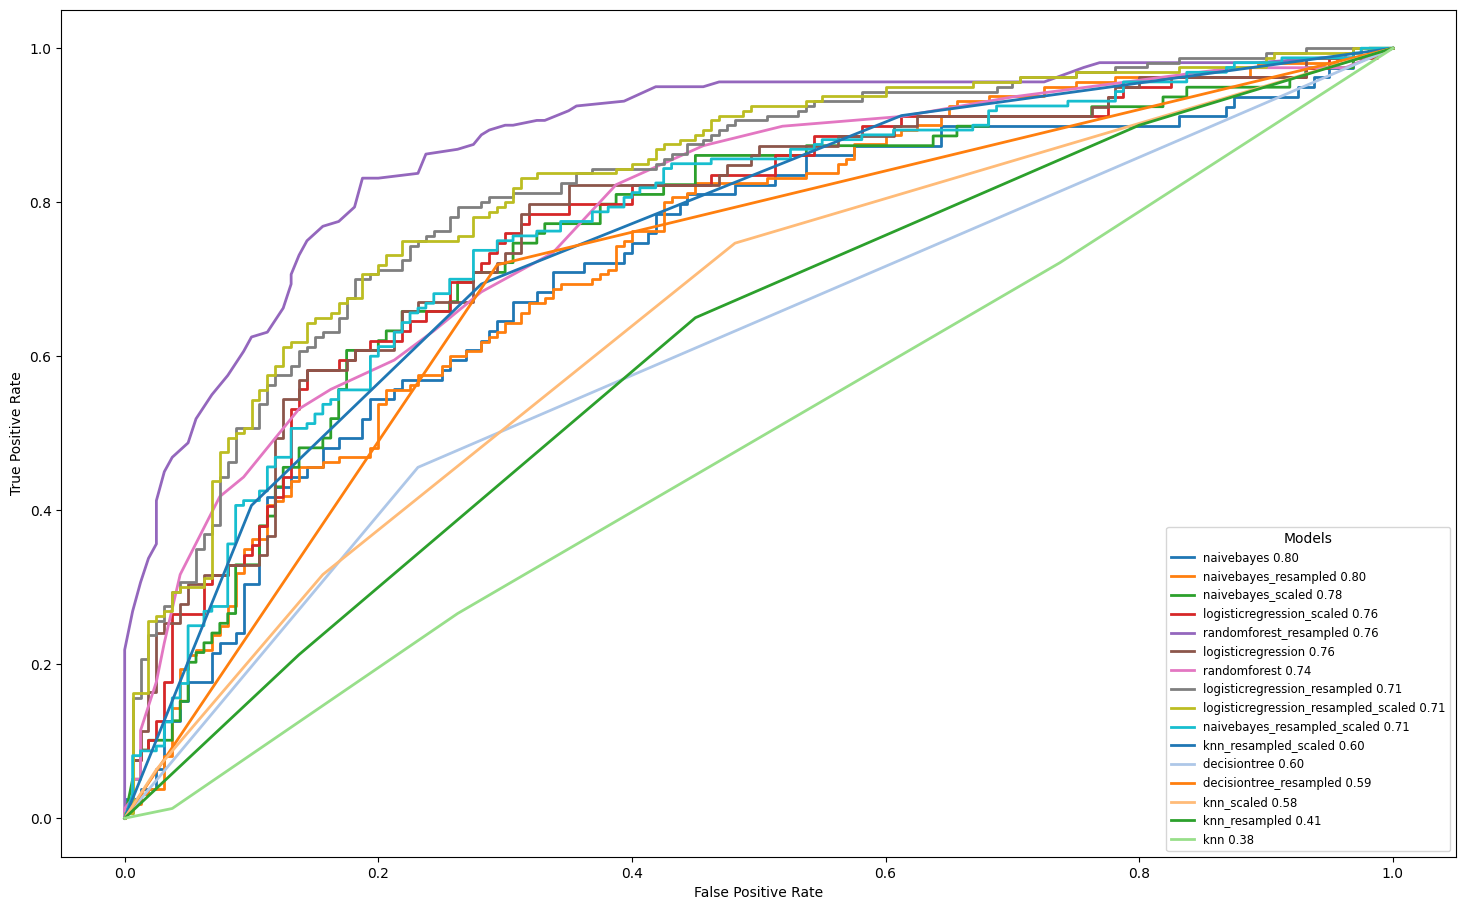

In [93]:
plt.figure(figsize=(18, 11))
distinct_colors = plt.cm.tab10.colors + plt.cm.tab20.colors
distinct_colors = distinct_colors[:len(models)]
for i, m in enumerate(sorted(models.items(), key=lambda item: item[1].roc_AUC or 0, reverse=True)):
    model_name, model = m
    if models[model_name].roc_AUC is None: continue
    plt.plot(models[model_name].roc_fpr, models[model_name].roc_tpr, color=distinct_colors[i], lw=2, label=f"{model_name} {models[model_name].roc_AUC:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='best', fontsize='small', title='Models')
plt.show()